Лабораторная работа №6. Применение сверточных нейронных сетей (многоклассовая классификация)


In [8]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import scipy.io
from sklearn.model_selection import train_test_split
import tarfile
from six.moves import cPickle as pickle
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.

In [9]:
def read_images(filename):
    images = []
    with open(filename) as f:
        f.readline()
        for line in f:
            label, *values = line.strip().split(',')
            image = np.array([float(v) for v in values]) / 255
            image.resize((28, 28, 1))
            images.append((int(label), image))

    labels = [p[0] for p in images]
    images = [p[1] for p in images]
    return np.array(labels), np.array(images)

test_labels, test_images = read_images("../data/sign_mnist/sign_mnist_test.csv")
train_labels, train_images = read_images("../data/sign_mnist/sign_mnist_train.csv")
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels)

classes = sorted(list(set(list(train_labels) + list(valid_labels) + list(test_labels))))

print(len(train_images), len(train_labels), len(test_images), len(test_labels), len(valid_images), len(valid_labels))

20591 20591 7172 7172 6864 6864


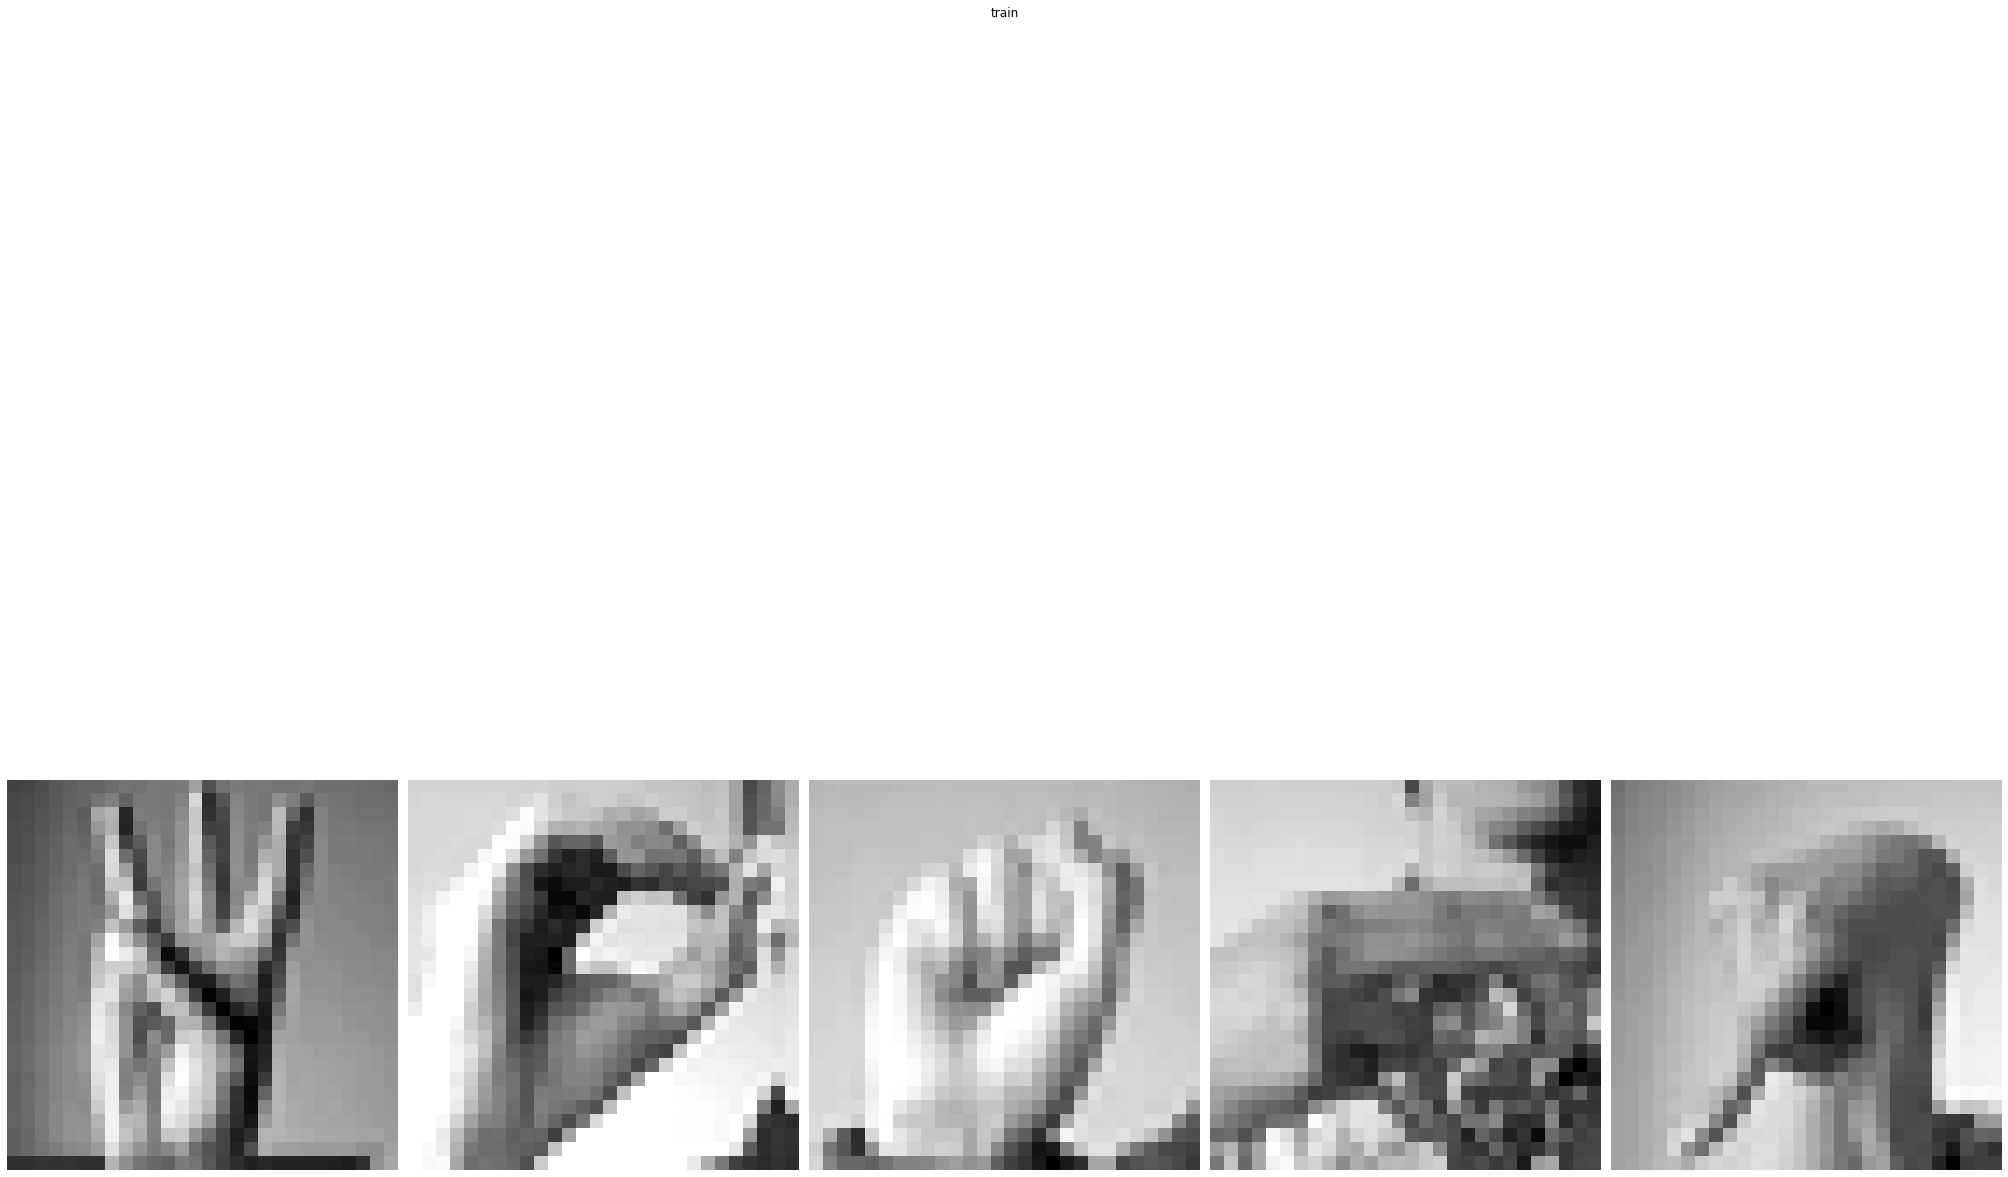

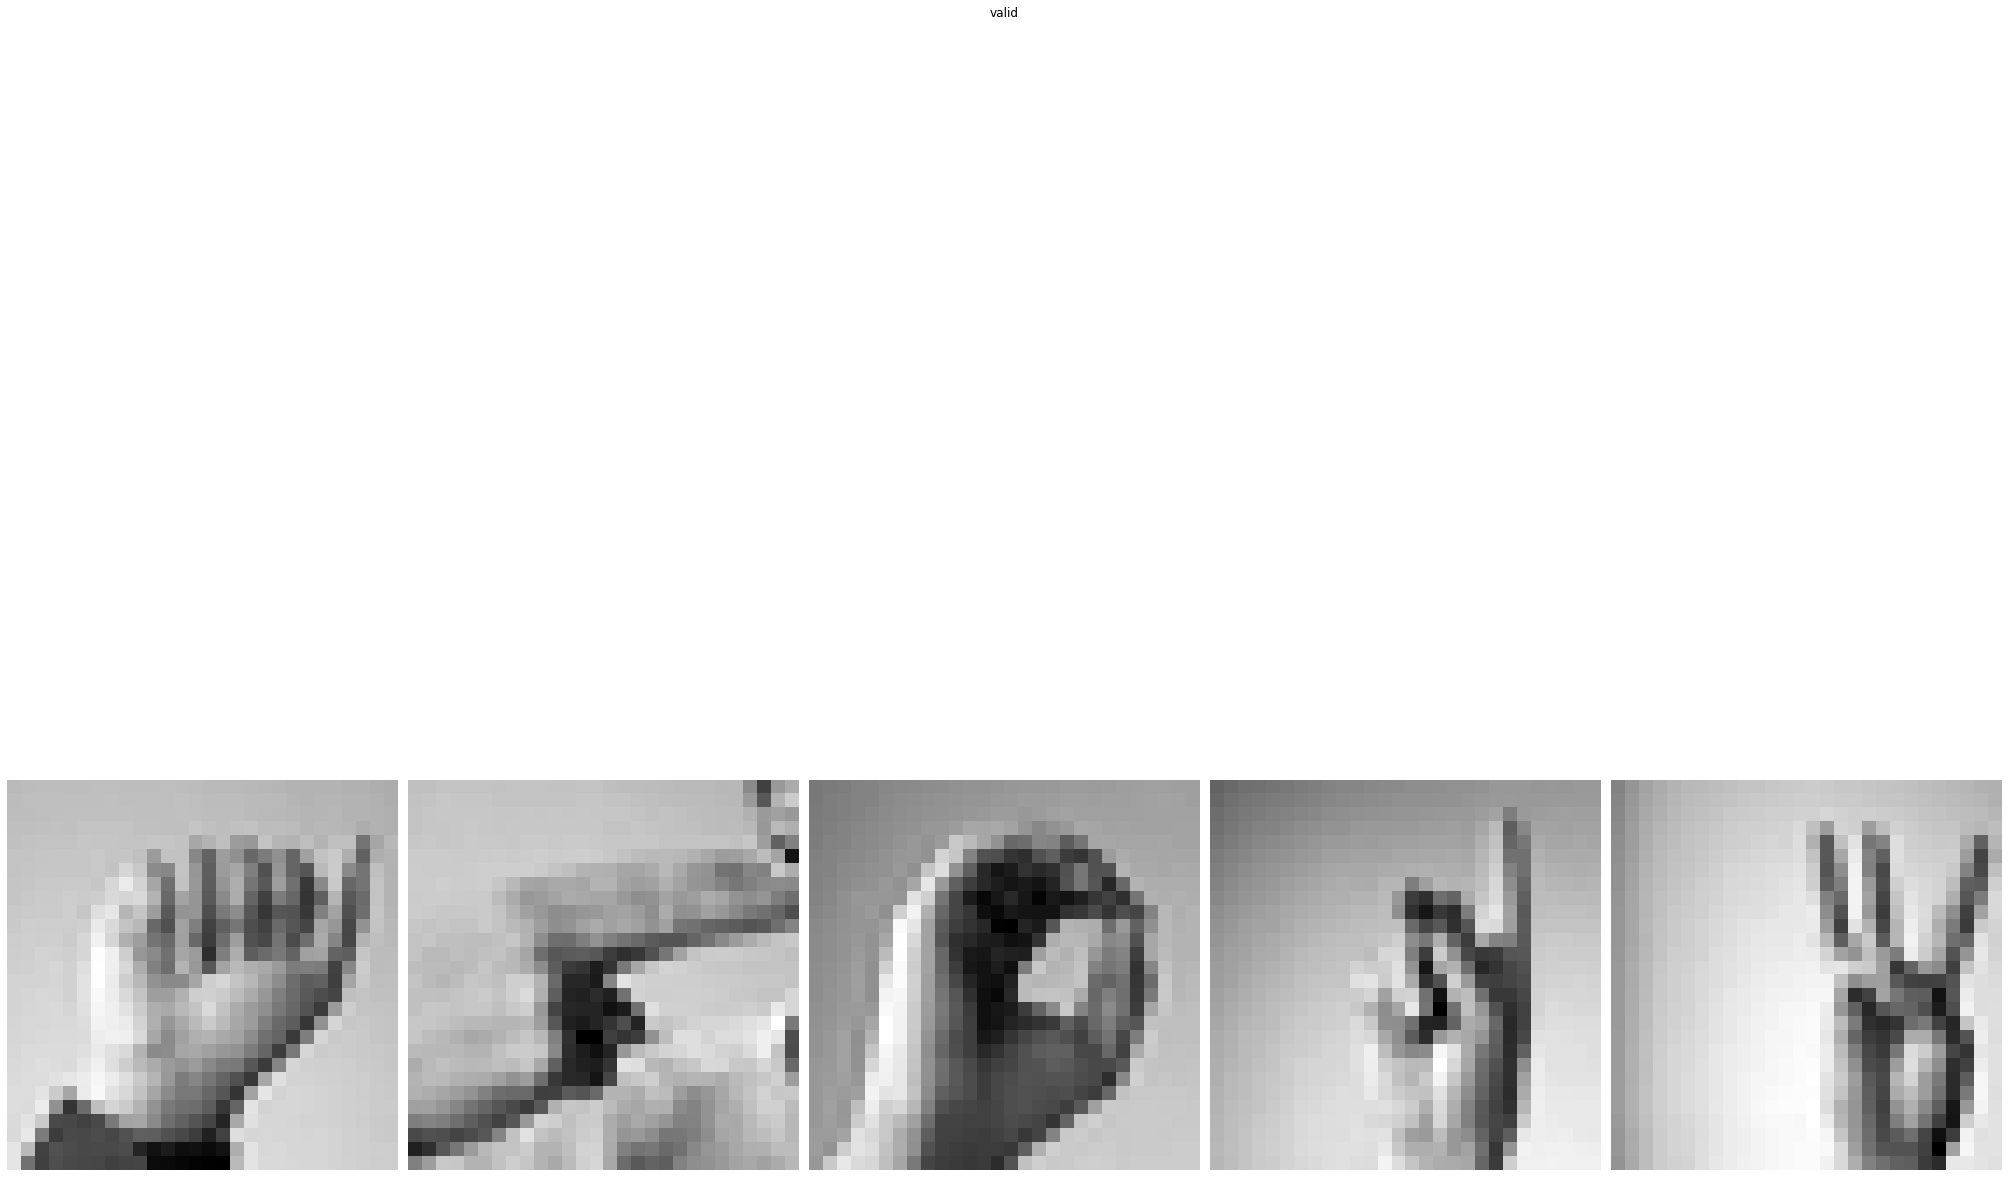

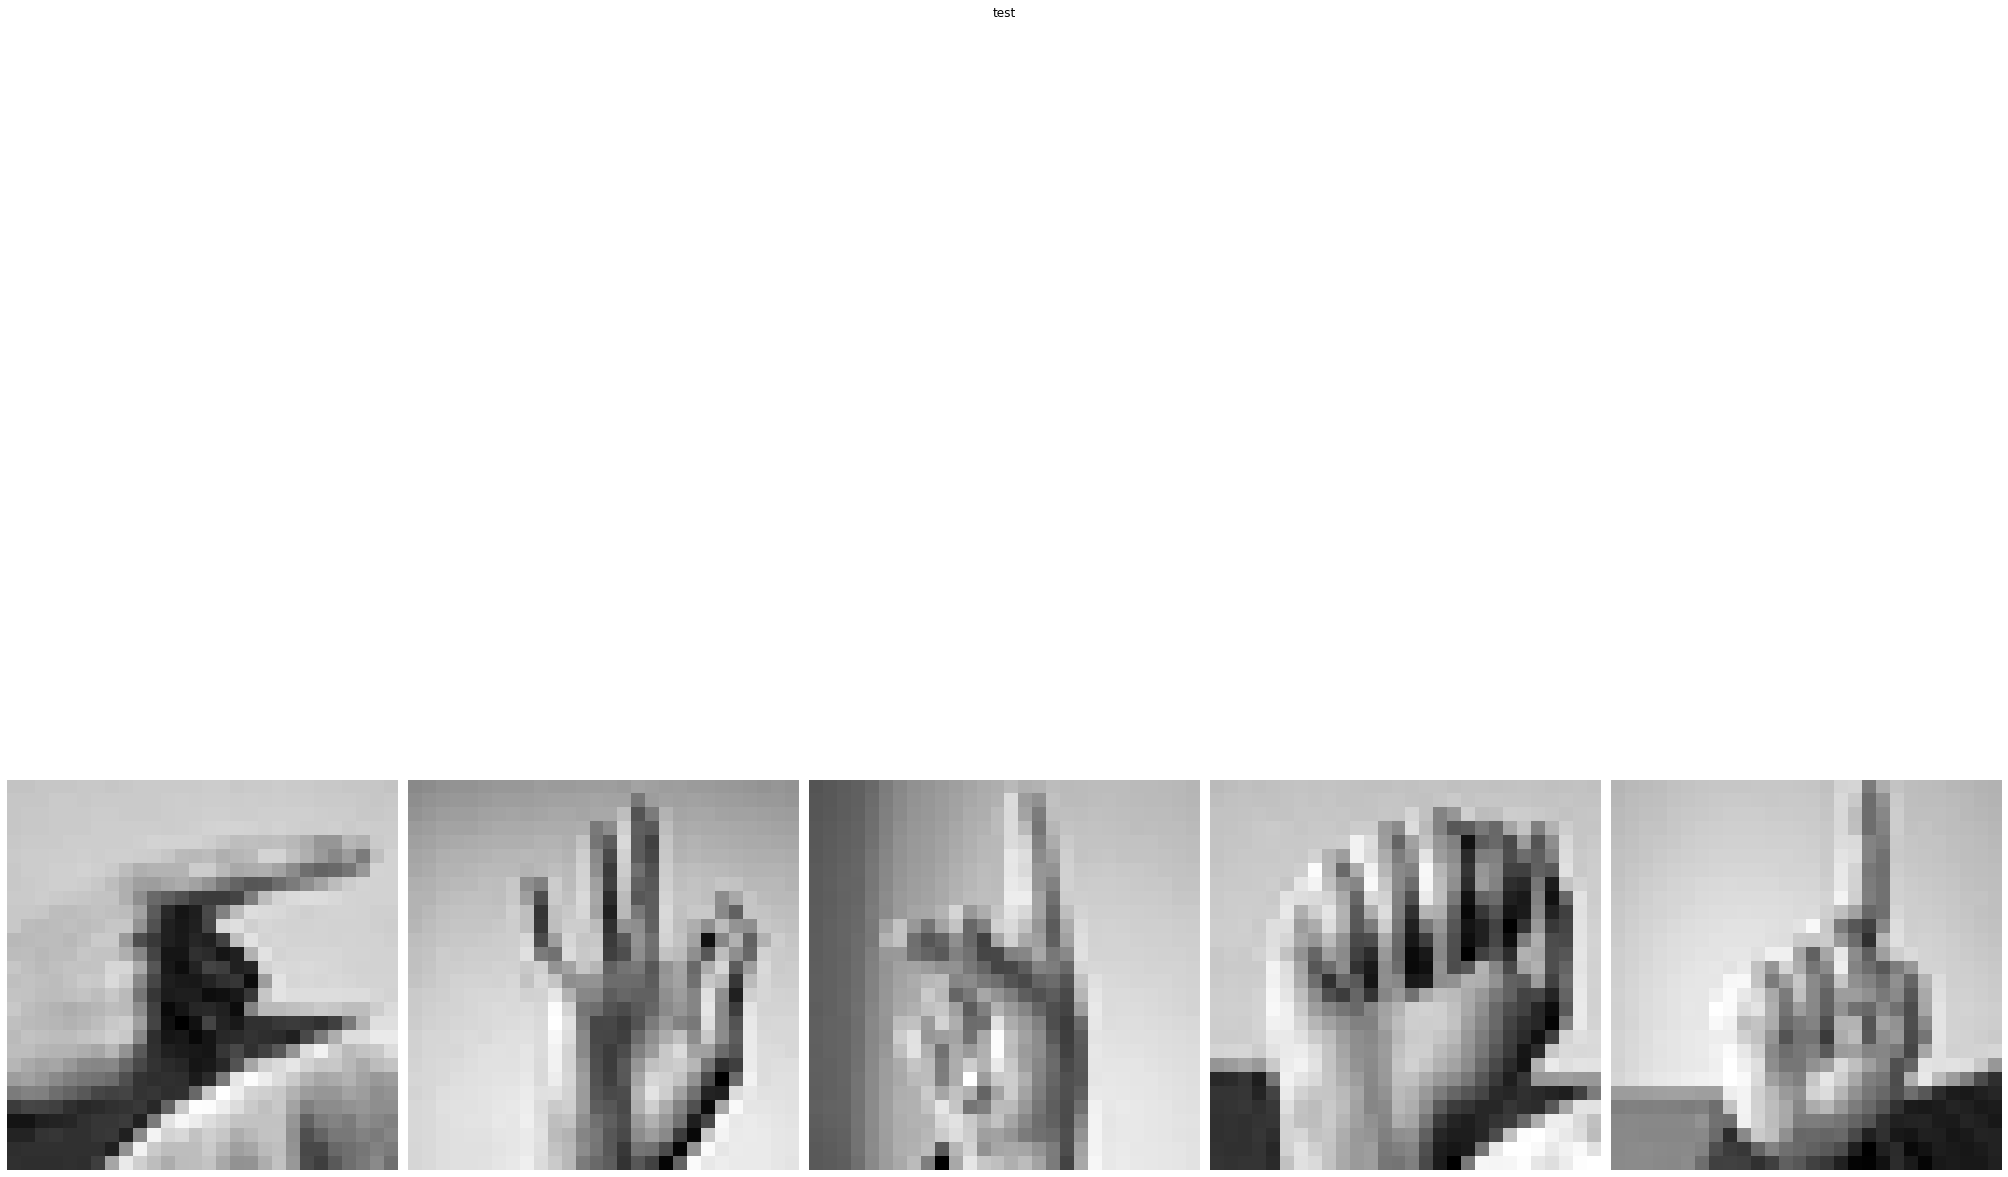

In [10]:
def plot_samples(images, sample_size, name):
    figure, axes = plt.subplots(1, sample_size, figsize=(28, 28))
    figure.suptitle(name)
    axes = axes.flatten()
    imgs = images[:sample_size]
    for img, ax in zip(imgs, axes):
        img = np.array(img)
        img.resize((28, 28))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_samples(train_images, 5, 'train')
plot_samples(valid_images, 5, 'valid')
plot_samples(test_images, 5, 'test')

Задание 2.
Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?


In [11]:
l2_regularization = 1e-4
num_classes = max(classes) + 1

basic_model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(units=num_classes, activation = 'softmax')
])

basic_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

basic_model.summary()
basic_model_history = basic_model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))
test_loss, test_acc = basic_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

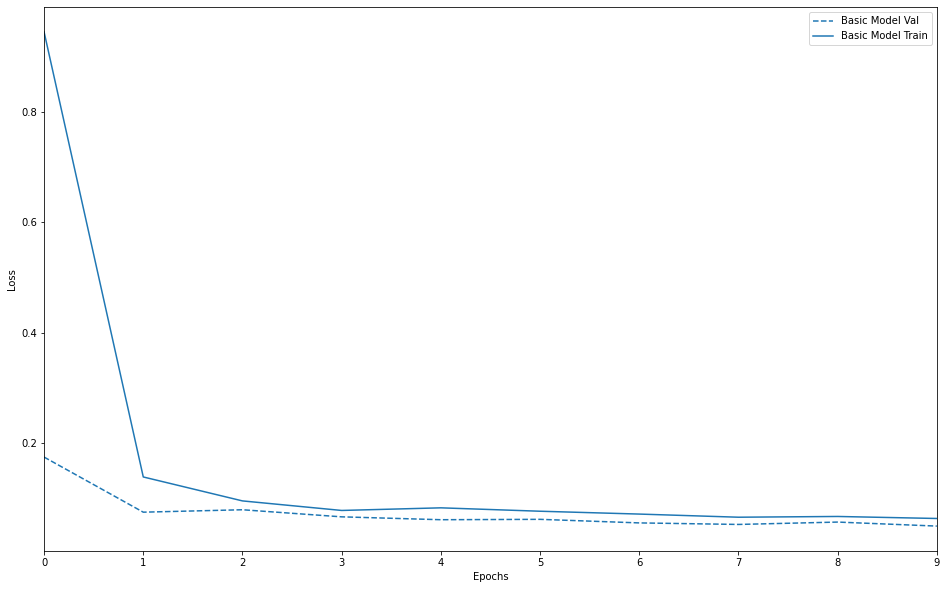

In [12]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                        '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.show()

plot_history([('basic model', basic_model_history)], key='loss')

Задание 3.
Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 


In [19]:
aug_train_image_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
).flow(train_images, train_labels, batch_size=64, shuffle=True)

aug_valid_image_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
).flow(valid_images, valid_labels, batch_size=64, shuffle=True)

aug_test_image_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
).flow(test_images, test_labels, batch_size=64, shuffle=True)

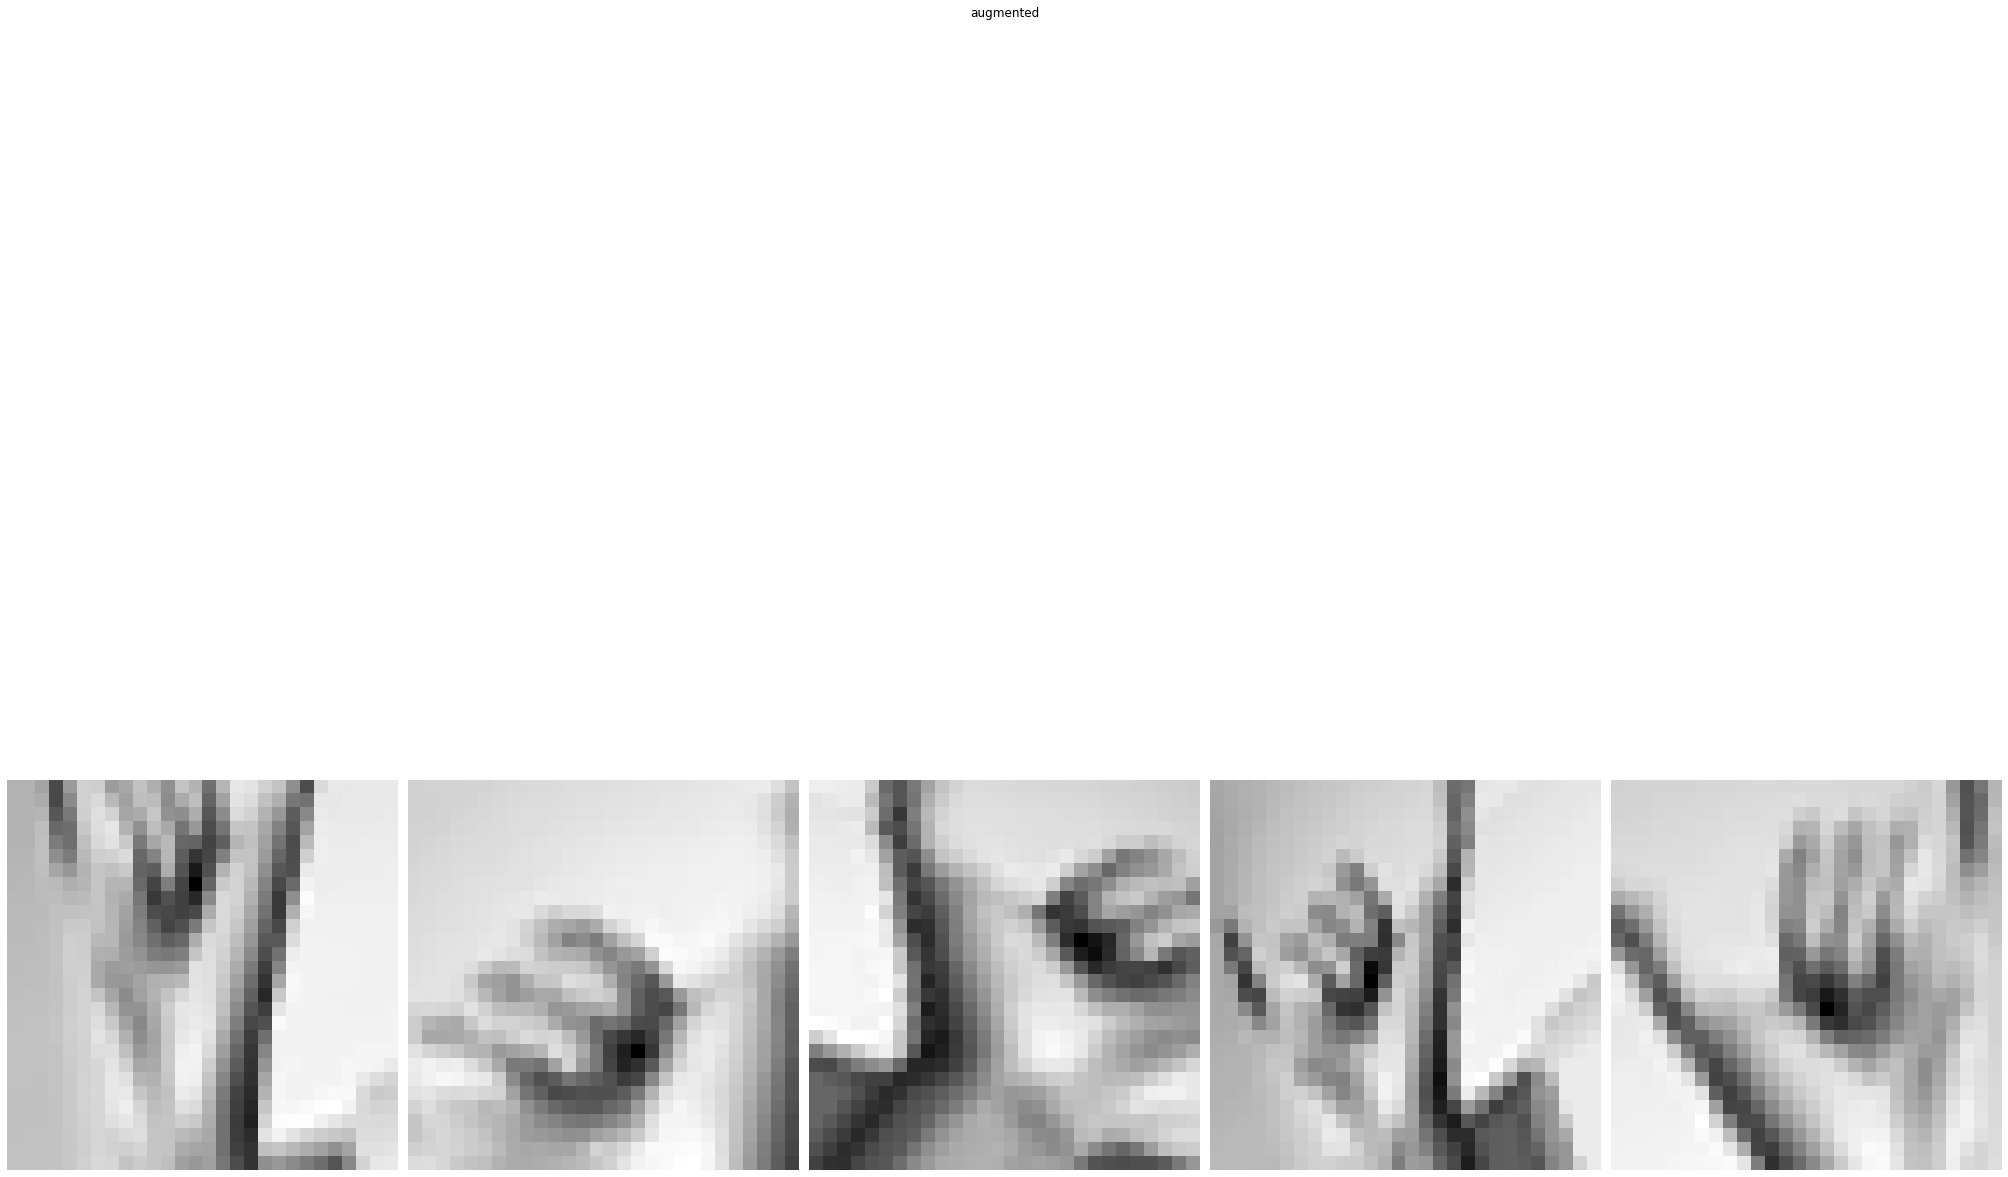

In [18]:
plot_samples([aug_train_image_gen[0][0][0] for i in range(5)], 5, 'augmented')

In [21]:
l2_regularization = 1e-4
num_classes = max(classes) + 1

aug_model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(units=num_classes, activation = 'softmax')
])

aug_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

aug_model.summary()
aug_model_history = aug_model.fit(aug_train_image_gen, epochs=42, validation_data=aug_valid_image_gen)
test_loss, test_acc = aug_model.evaluate(aug_test_image_gen, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

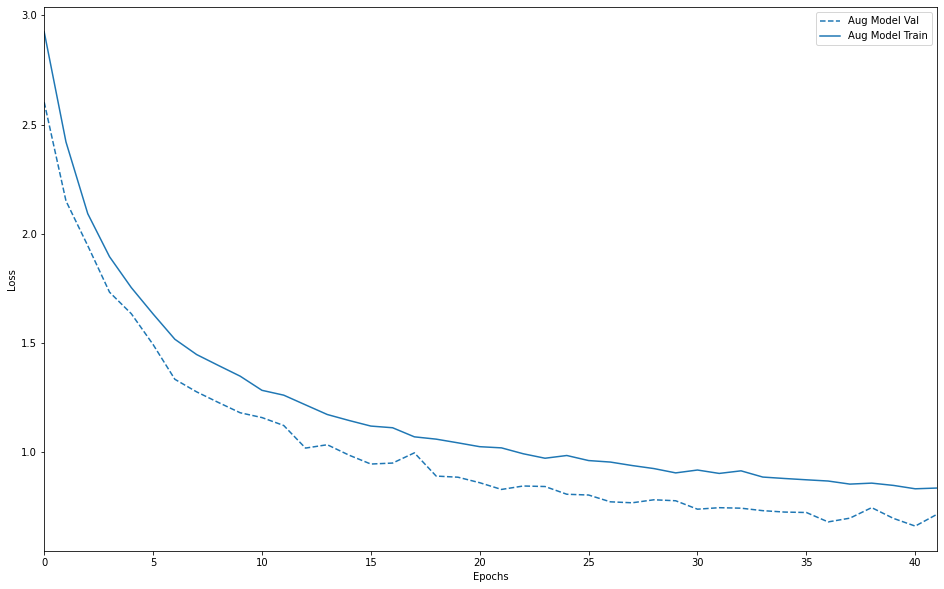

In [22]:
plot_history([('aug model', aug_model_history)], key='loss')

Задание 4.
Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него?


In [23]:
pre_trained_model = keras.applications.VGG19(input_shape=(32, 32, 3), include_top=False, weights="imagenet")

for i, layer in enumerate(pre_trained_model.layers):
    if i <= 42:
        layer.trainable = False
    else:
        layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

model = keras.layers.GlobalAveragePooling2D()(last_output)
model = keras.layers.Dense(512, activation='relu')(model)
model = keras.layers.Dropout(0.5)(model)
model = keras.layers.Dense(25, activation='softmax')(model)

vgg_model = keras.models.Model(pre_trained_model.input, model)

vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [24]:
# форматируем данные, чтобы они подходили под параметры входа модели.

train_images_3d = np.array([np.repeat(img, 3, 2) for img in tf.image.resize(train_images, (32, 32))])
valid_images_3d = np.array([np.repeat(img, 3, 2) for img in tf.image.resize(valid_images, (32, 32))])
test_images_3d = np.array([np.repeat(img, 3, 2) for img in tf.image.resize(test_images, (32, 32))])


In [27]:
vgg_model_history = vgg_model.fit(
    train_images_3d, train_labels, 
    epochs=2,
    validation_data=(valid_images_3d, valid_labels), 
    validation_steps=10,
    verbose=1)

test_loss, test_acc = aug_model.evaluate(test_images_3d, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

NameError: name 'val_images_3d' is not defined

In [26]:
plot_history([('vgg model', vgg_model_history)], key='loss')

NameError: name 'vgg_model_history' is not defined